# Importing Important Libraries

In [64]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [65]:
def convert_txt_to_csv(txt_file, csv_file):
    """
    Convert a space-separated txt file to a csv file
    """
    # Read the txt file
    data = pd.read_csv(txt_file, sep=' ', header=None)
    
    # Save as csv file
    data.to_csv(csv_file, index=False, header=False)
    
    print(f"Converted {txt_file} to {csv_file}")

# Example usage
txt_file = "labels.txt"
csv_file = "labels.csv"
convert_txt_to_csv(txt_file, csv_file)

Converted labels.txt to labels.csv


# Analyzing the data 

In [66]:
def analyze_target_file(target_csv):
    """
    Analyze target.csv to get counts of samples
    """
    # Read target file
    targets = pd.read_csv(target_csv)
    
    # Calculate total samples
    total_samples = len(targets)
    
    # Calculate samples per label
    label_counts = targets['labels'].value_counts()
    
    print(f"Total number of samples: {total_samples}")
    print("\nSamples per label:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
        
    # Print counts for binary classifications
    print("\nBinary classification counts:")
    
    # Face vs House
    face_house = targets[targets['labels'].isin(['face', 'house'])]
    face_count = len(face_house[face_house['labels'] == 'face'])
    house_count = len(face_house[face_house['labels'] == 'house'])
    print(f"\nFace vs House:")
    print(f"Face: {face_count}")
    print(f"House: {house_count}")
    print(f"Total: {face_count + house_count}")
    
    # Face vs cat
    face_cat = targets[targets['labels'].isin(['face', 'cat'])]
    face_count = len(face_cat[face_cat['labels'] == 'face'])
    cat_count = len(face_cat[face_cat['labels'] == 'cat'])
    print(f"\nFace vs cat:")
    print(f"Face: {face_count}")
    print(f"cat: {cat_count}")
    print(f"Total: {face_count + cat_count}")

if __name__ == "__main__":
    TARGET_CSV = "labels.csv"
    analyze_target_file(TARGET_CSV)

Total number of samples: 1452

Samples per label:
rest: 660
face: 99
cat: 99
shoe: 99
chair: 99
scissors: 99
bottle: 99
house: 99
scrambledpix: 99

Binary classification counts:

Face vs House:
Face: 99
House: 99
Total: 198

Face vs cat:
Face: 99
cat: 99
Total: 198


## Processing the data chunck wise

In [67]:
def create_binary_dataset(base_folder, region, target_csv, label1, label2):
    """
    Create binary classification dataset for one region, organized by chunks
    """
    print(f"\nProcessing {label1} vs {label2} for region {region}")
    
    # Read feature file (space-separated, no header)
    if region == "vt":
        feature_file = os.path.join(base_folder, region, "features.csv")
        features = pd.read_csv(feature_file, header=None, sep=' ')
    else:
        region_full = os.path.join(region, "RL")
        feature_file = os.path.join(base_folder, region_full, "features.csv")
        features = pd.read_csv(feature_file, header=None, sep=' ')

    # Read target labels
    targets = pd.read_csv(target_csv)
    
    # Initialize lists to store data for each chunk
    all_features = []
    all_labels = []
    all_label_names = []
    
    # Process each chunk (0 to 11)
    for chunk in range(12):
        # Filter for required labels in current chunk
        chunk_mask = (targets['labels'].isin([label1, label2])) & (targets['chunks'] == chunk)
        filtered_chunk_targets = targets[chunk_mask]
        
        # Get features for selected labels using row indices
        selected_features = features.iloc[filtered_chunk_targets.index]
        
        # Create binary labels (0 for label1, 1 for label2)
        binary_labels = (filtered_chunk_targets['labels'] == label2).astype(int)
        
        # Append to lists
        all_features.append(selected_features)
        all_labels.append(binary_labels)
        all_label_names.append(filtered_chunk_targets['labels'])
    
    # Concatenate all chunks
    final_features = pd.concat(all_features, axis=0)
    final_labels = pd.concat(all_labels, axis=0)
    final_label_names = pd.concat(all_label_names, axis=0)
    
    # Create final dataframe
    final_df = final_features.copy()
    final_df['label'] = final_labels.values
    final_df['label_name'] = final_label_names.values
    
    # Save to CSV without index and without numbering the feature columns
    output_file = f"{region}_{label1}_vs_{label2}.csv"
    final_df.to_csv(output_file, index=False, header=False)
    
    print(f"Created {output_file}")
    print(f"Number of {label1}: {sum(final_labels == 0)}")
    print(f"Number of {label2}: {sum(final_labels == 1)}")
    
    # Print chunk-wise statistics
    for chunk in range(12):
        chunk_mask = targets['chunks'] == chunk
        chunk_data = final_df[chunk_mask]
        print(f"\nChunk {chunk}:")
        print(f"Number of {label1}: {sum((chunk_data['label'] == 0))}")
        print(f"Number of {label2}: {sum((chunk_data['label'] == 1))}")

def main():
    # Settings
    BASE_FOLDER = "subj5"  # Change this to your base folder path
    REGIONS = ["vt", "Superior_temporal"]
    TARGET_CSV = "labels.csv"
    
    # Process each region
    for region in REGIONS:
        # Create face vs house dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "house")
        
        # Create face vs cat dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "cat")

if __name__ == "__main__":
    main()


Processing face vs house for region vt
Created vt_face_vs_house.csv
Number of face: 99
Number of house: 99

Chunk 0:
Number of face: 9
Number of house: 9

Chunk 1:
Number of face: 9
Number of house: 9

Chunk 2:
Number of face: 9
Number of house: 9

Chunk 3:
Number of face: 9
Number of house: 9

Chunk 4:
Number of face: 9
Number of house: 9

Chunk 5:
Number of face: 9
Number of house: 9

Chunk 6:
Number of face: 9
Number of house: 9

Chunk 7:
Number of face: 9
Number of house: 9

Chunk 8:
Number of face: 0
Number of house: 0

Chunk 9:
Number of face: 9
Number of house: 9

Chunk 10:
Number of face: 9
Number of house: 9

Chunk 11:
Number of face: 9
Number of house: 9

Processing face vs cat for region vt


/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6

Created vt_face_vs_cat.csv
Number of face: 99
Number of cat: 99

Chunk 0:
Number of face: 9
Number of cat: 9

Chunk 1:
Number of face: 9
Number of cat: 9

Chunk 2:
Number of face: 9
Number of cat: 9

Chunk 3:
Number of face: 9
Number of cat: 9

Chunk 4:
Number of face: 9
Number of cat: 9

Chunk 5:
Number of face: 9
Number of cat: 9

Chunk 6:
Number of face: 9
Number of cat: 9

Chunk 7:
Number of face: 9
Number of cat: 9

Chunk 8:
Number of face: 0
Number of cat: 0

Chunk 9:
Number of face: 9
Number of cat: 9

Chunk 10:
Number of face: 9
Number of cat: 9

Chunk 11:
Number of face: 9
Number of cat: 9

Processing face vs house for region Superior_temporal
Created Superior_temporal_face_vs_house.csv
Number of face: 99
Number of house: 99

Chunk 0:
Number of face: 9
Number of house: 9

Chunk 1:
Number of face: 9
Number of house: 9

Chunk 2:
Number of face: 9
Number of house: 9

Chunk 3:
Number of face: 9
Number of house: 9

Chunk 4:
Number of face: 9
Number of house: 9

Chunk 5:
Number of f

/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6sg2x4g_542rfj480000gn/T/ipykernel_14925/2007025188.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chunk_data = final_df[chunk_mask]
/var/folders/38/42jnccns6

## New Training and validation with session wise

In [71]:
def load_and_preprocess(file_path, mode="all_features"):
    """Load and preprocess the data with chunk information"""
    # Read CSV
    data = pd.read_csv(file_path, header=None)
    
    # Last two columns are label and label_name
    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2].values  # Binary label (0 or 1)
    label_names = data.iloc[:, -1].values  # Label names
    
    
    # Calculate chunk sizes based on the structure (assuming equal chunks)
    samples_per_label_per_chunk = 9  # From your data structure
    chunk_size = samples_per_label_per_chunk * 2  # For both classes in each chunk
    total_chunks = 11
    
    # Create chunk labels (0-11 repeated for each chunk's samples)
    chunks = np.repeat(np.arange(total_chunks), chunk_size)
    
    if mode != "all_features":
        np.random.seed(42)
        n_features = X.shape[1]
        select = np.random.choice(n_features, n_features//2, replace=False)
        selected_indices = np.sort(select)
        
        # Update data with selected samples
        X = X[:,selected_indices]
        
    
    # Print dataset information
    unique_labels, counts = np.unique(label_names, return_counts=True)
    print("\nDataset Information:")
    print(f"Total samples: {len(y)}")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, chunks

def train_and_evaluate_models(X, y, chunks, contrast_name):
    """Train and evaluate models using leave-one-chunk-out cross-validation"""
    print(f"\n{contrast_name} Information:")
    print(f"Total samples: {len(y)} ({np.sum(y == 0)} class 0, {np.sum(y == 1)} class 1)")
    
    # Define models
    models = {
        'RF': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
        'SVM': SVC(kernel='rbf', C=1.0, random_state=42)
    }
    
    # Results storage
    results = {}
    cv_scores = {}
    chunk_accuracies = {}  # Store accuracies for each chunk
    
    for name, model in models.items():
        print(f"\nTraining {name} for {contrast_name}...")
        scores = []
        chunk_scores = {i: [] for i in range(11)}  # Initialize scores for each chunk
        
        # Leave-one-chunk-out cross-validation
        for test_chunk in range(11):
            # Split data
            train_mask = chunks != test_chunk
            test_mask = chunks == test_chunk
            print("train mask", train_mask.shape)
            print("test mask", test_mask.shape)
            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]
            
            # Train and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate accuracy
            acc = accuracy_score(y_test, y_pred)
            scores.append(acc)
            chunk_scores[test_chunk] = acc
            
        # Store results
        cv_scores[name] = np.array(scores)
        results[name] = np.mean(scores)
        chunk_accuracies[name] = chunk_scores
        
        print(f"Mean CV accuracy: {results[name]:.3f} (+/- {np.std(scores)*2:.3f})")
        print("\nSession-wise accuracies:")
        for chunk, acc in chunk_scores.items():
            print(f"Session {chunk}: {acc:.3f}")
    
    return results, cv_scores, chunk_accuracies

def plot_results(vt_face_house_cv, vt_face_cat_cv, chunk_accuracies_house, chunk_accuracies_cat, region):
    """Create plots for the results"""
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)
    
    # 1. Overall boxplot
    ax1 = fig.add_subplot(gs[0, 0])
    data_to_plot = [
        vt_face_house_cv['RF'], vt_face_house_cv['SVM'],
        vt_face_cat_cv['RF'], vt_face_cat_cv['SVM']
    ]
    labels = ['RF\nFace vs House', 'SVM\nFace vs House', 
              'RF\nFace vs cat', 'SVM\nFace vs cat']
    
    ax1.boxplot(data_to_plot, labels=labels)
    ax1.set_title('Overall Classification Accuracy\n(Leave-one-chunk-out CV)')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # 2. Mean accuracy bar plot
    ax2 = fig.add_subplot(gs[0, 1])
    models = ['Random Forest', 'SVM']
    face_house_means = [np.mean(vt_face_house_cv['RF']), np.mean(vt_face_house_cv['SVM'])]
    face_cat_means = [np.mean(vt_face_cat_cv['RF']), np.mean(vt_face_cat_cv['SVM'])]
    
    x = np.arange(len(models))
    width = 0.35
    ax2.bar(x - width/2, face_house_means, width, label='Face vs House')
    ax2.bar(x + width/2, face_cat_means, width, label='Face vs Cat')
    ax2.set_ylabel('Mean Accuracy')
    ax2.set_title('Mean Classification Accuracy by Model')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Chunk-wise accuracy plot for Face vs House
    ax3 = fig.add_subplot(gs[1, 0])
    chunks = range(11)
    ax3.plot(chunks, [chunk_accuracies_house['RF'][i] for i in chunks], 'o-', label='RF')
    ax3.plot(chunks, [chunk_accuracies_house['SVM'][i] for i in chunks], 's-', label='SVM')
    ax3.set_title('Session-wise Accuracy: Face vs House')
    ax3.set_xlabel('Session Number')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Chunk-wise accuracy plot for Face vs Cat
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(chunks, [chunk_accuracies_cat['RF'][i] for i in chunks], 'o-', label='RF')
    ax4.plot(chunks, [chunk_accuracies_cat['SVM'][i] for i in chunks], 's-', label='SVM')
    ax4.set_title('Session-wise Accuracy: Face vs cat')
    ax4.set_xlabel('Session Number')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    figure_name = "classification_results_" + region + ".png"
    plt.savefig(figure_name, dpi=300, bbox_inches='tight')
    plt.show()



In [73]:
def run(data1, data2, mode="all_features", region = "vt"):
    print("=== VT Region Classification Analysis ===")
    
    # Load and process data
    print(f"\nProcessing {data1}")
    X_face_house, y_face_house, chunks_face_house = load_and_preprocess(data1, mode)
    print(X_face_house.shape, y_face_house.shape, chunks_face_house.shape)
    
    print(f"\nProcessing {data2}")
    X_face_cat, y_face_cat, chunks_face_cat = load_and_preprocess(data2, mode)
    
    # Train and evaluate models
    results_face_house, cv_scores_face_house, chunk_acc_house = train_and_evaluate_models(
        X_face_house, y_face_house, chunks_face_house, "Face vs House")
    
    results_face_cat, cv_scores_face_cat, chunk_acc_cat = train_and_evaluate_models(
        X_face_cat, y_face_cat, chunks_face_cat, "Face vs cat")
    
    # Summary of results
    print("\n=== Summary of Results ===")
    print("\nFace vs House:")
    for name, acc in results_face_house.items():
        cv_mean = np.mean(cv_scores_face_house[name])
        cv_std = np.std(cv_scores_face_house[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    print("\nFace vs cat:")
    for name, acc in results_face_cat.items():
        cv_mean = np.mean(cv_scores_face_cat[name])
        cv_std = np.std(cv_scores_face_cat[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    # Create and save plots
    plot_results(cv_scores_face_house, cv_scores_face_cat, 
                chunk_acc_house, chunk_acc_cat, region)

## Binary Classification of VT region (all fetures) (face vs house) and (face vs cat)


=== VT Region Classification Analysis ===

Processing vt_face_vs_house.csv

Dataset Information:
Total samples: 198
face: 99 samples
house: 99 samples
(198, 422) (198,) (198,)

Processing vt_face_vs_cat.csv

Dataset Information:
Total samples: 198
cat: 99 samples
face: 99 samples

Face vs House Information:
Total samples: 198 (99 class 0, 99 class 1)

Training RF for Face vs House...
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
Mean CV accuracy: 0.934 (+/- 0.211)

Session-wise accuracies:
Session 0: 0.667
Session 1: 0.944
Session 2: 1.000
Session 3: 0.778
Session 4: 1.000
Session 5: 1.000
Session 6: 1.000
Session 7: 1.000
Session 8: 1.000
Session 9: 0.

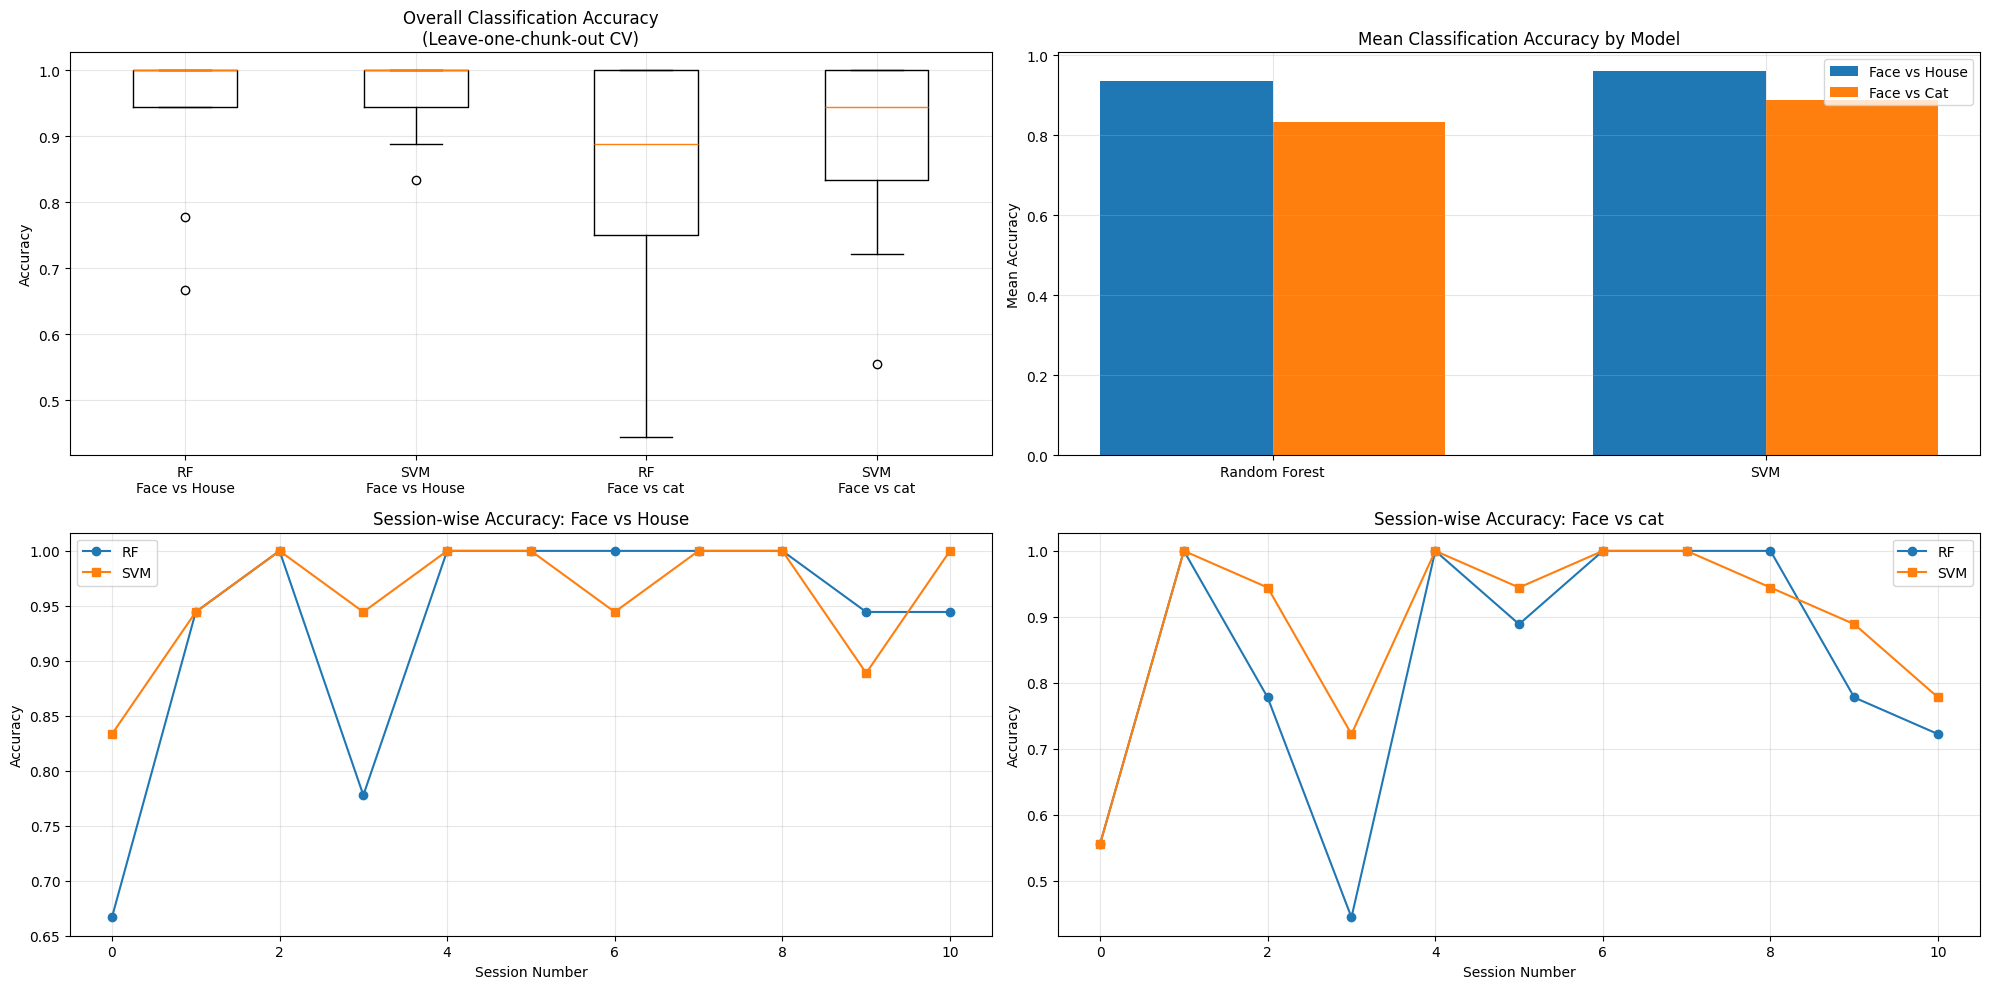

In [74]:
vt_face_house = "vt_face_vs_house.csv"
vt_face_cat = "vt_face_vs_cat.csv"
run(vt_face_house, vt_face_cat)

## Binary Classification of Superior_Temporal region (face vs house) and (face vs cat)

=== VT Region Classification Analysis ===

Processing Superior_temporal_face_vs_house.csv

Dataset Information:
Total samples: 198
face: 99 samples
house: 99 samples
(198, 92) (198,) (198,)

Processing Superior_temporal_face_vs_cat.csv

Dataset Information:
Total samples: 198
cat: 99 samples
face: 99 samples

Face vs House Information:
Total samples: 198 (99 class 0, 99 class 1)

Training RF for Face vs House...
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
Mean CV accuracy: 0.505 (+/- 0.330)

Session-wise accuracies:
Session 0: 0.500
Session 1: 0.667
Session 2: 0.611
Session 3: 0.500
Session 4: 0.111
Session 5: 0.333
Session 6: 0.556
Session 7: 0.500
S

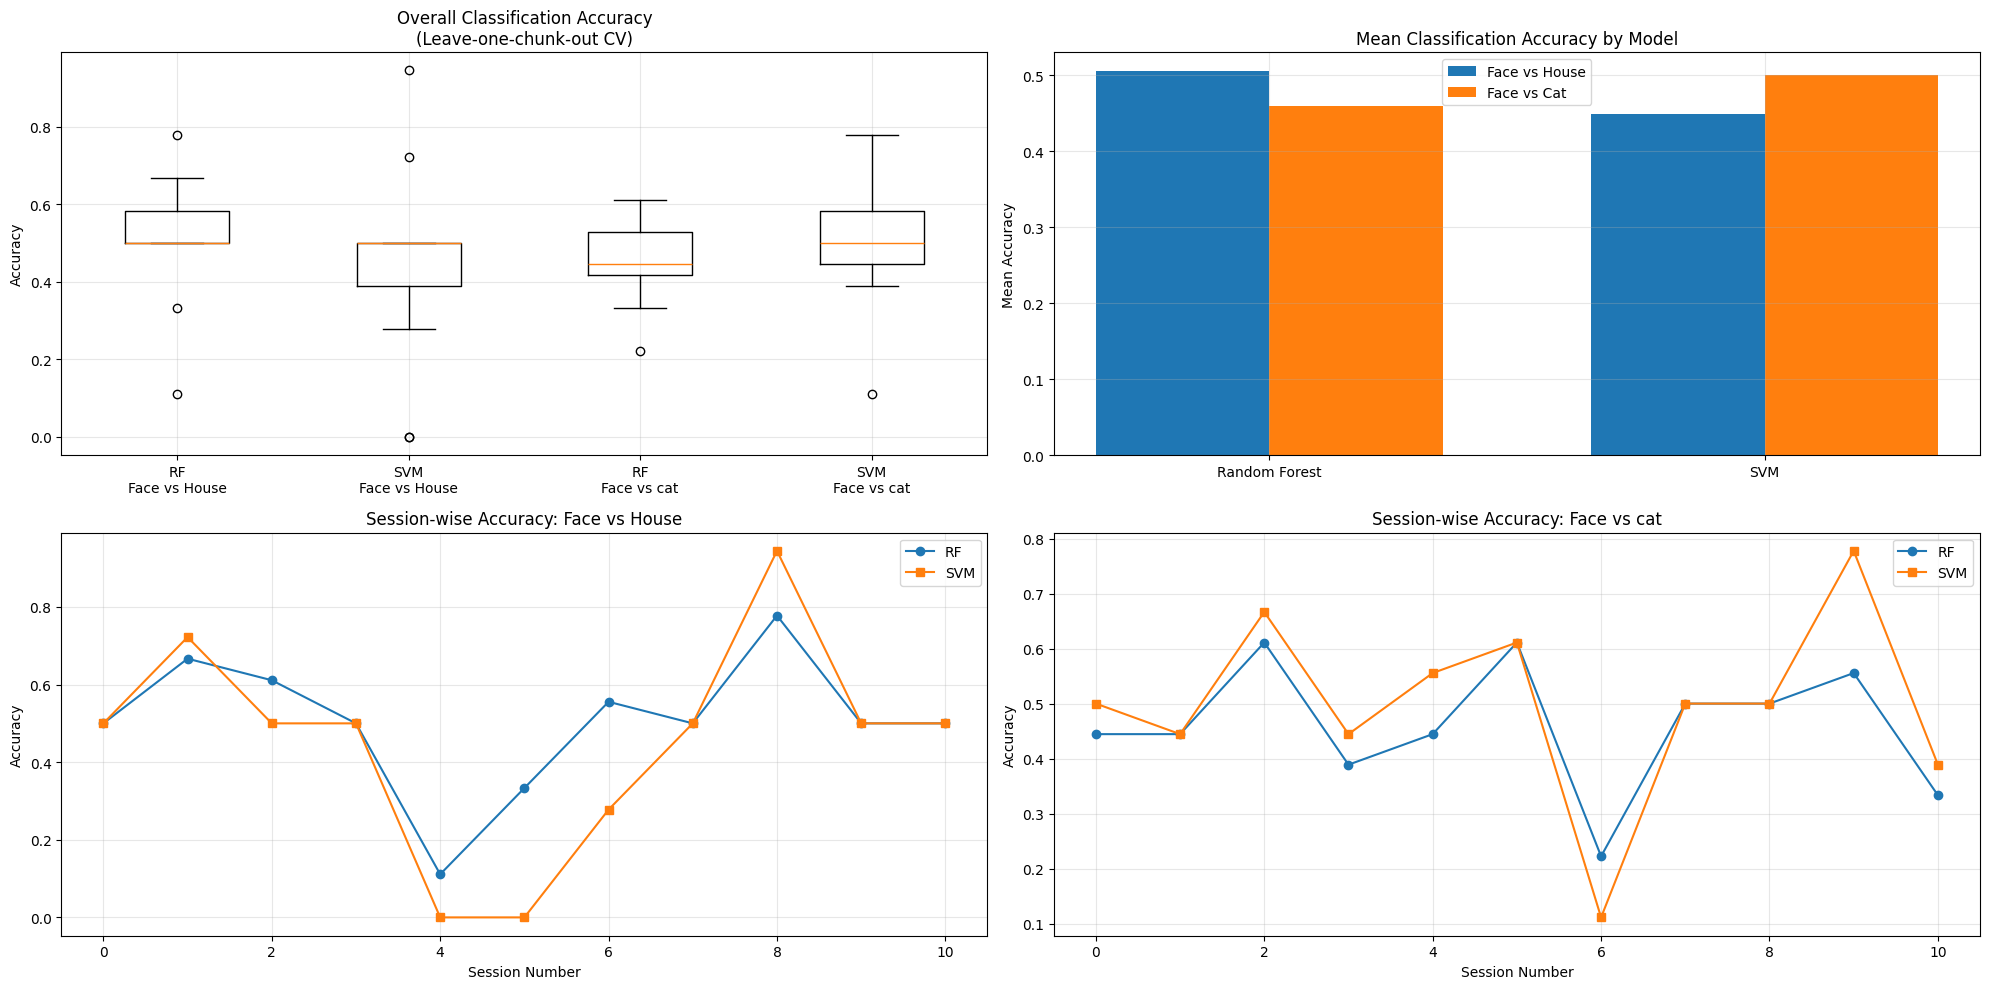

In [75]:
superior_face_house = "Superior_temporal_face_vs_house.csv"
superior_face_cat = "Superior_temporal_face_vs_cat.csv"

run(superior_face_house, superior_face_cat, mode = "all_features", region = "Superior_temporal")

## Binary Classification of VT region (50% fetures) (face vs house) and (face vs Cat)

=== VT Region Classification Analysis ===

Processing vt_face_vs_house.csv

Dataset Information:
Total samples: 198
face: 99 samples
house: 99 samples
(198, 211) (198,) (198,)

Processing vt_face_vs_cat.csv

Dataset Information:
Total samples: 198
cat: 99 samples
face: 99 samples

Face vs House Information:
Total samples: 198 (99 class 0, 99 class 1)

Training RF for Face vs House...
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
train mask (198,)
test mask (198,)
Mean CV accuracy: 0.929 (+/- 0.184)

Session-wise accuracies:
Session 0: 0.778
Session 1: 1.000
Session 2: 0.944
Session 3: 0.722
Session 4: 1.000
Session 5: 1.000
Session 6: 0.944
Session 7: 1.000
Session 8: 1.000
Session 9: 0.

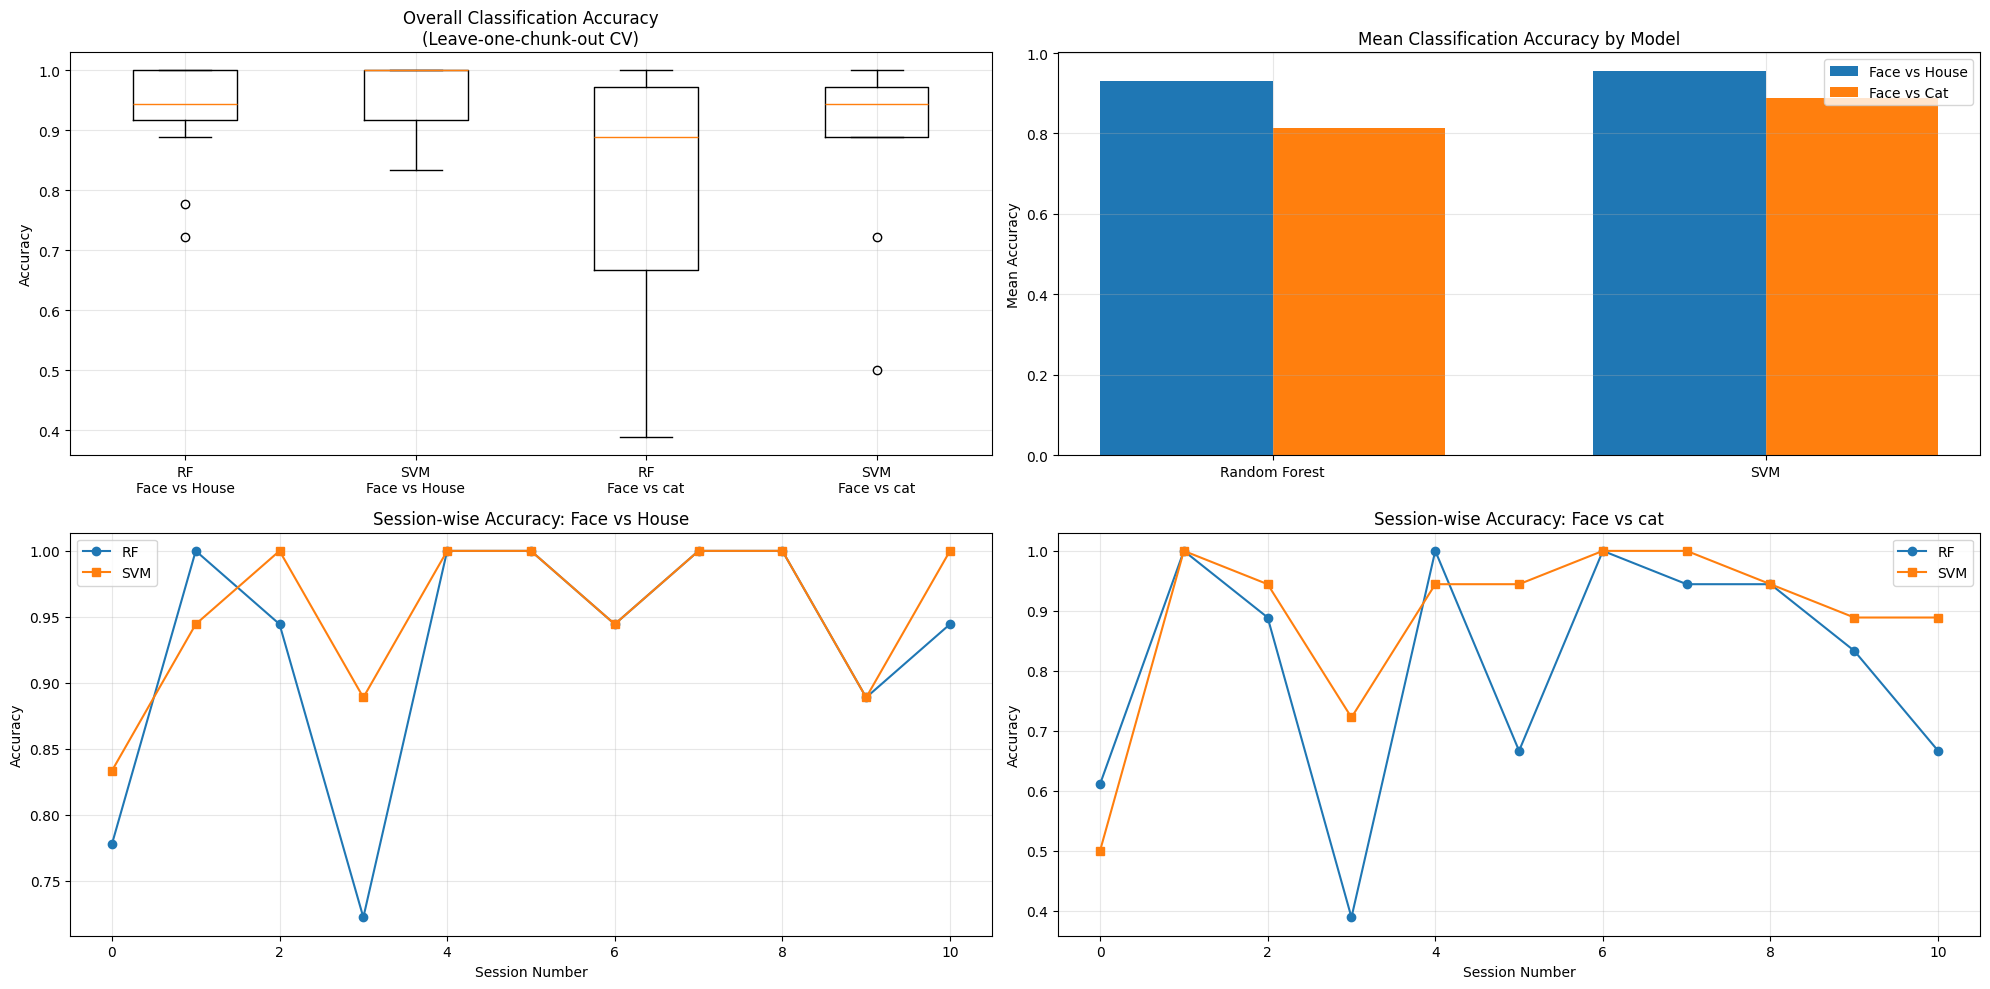

In [76]:
vt_face_house = "vt_face_vs_house.csv"
vt_face_cat = "vt_face_vs_cat.csv"
mode = "50_%_features"
run(vt_face_house, vt_face_cat, mode, region = "vt_50%")